# EDA for Overall Wells, Sicks, Labs, and Vaccines over (1/1/2020-3/31/2022)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import string
sns.set()

#### List of Insurance Abbreviations, as well as CPT Codes of Visit Categories: Well, Sick, Vaccine, and Lab

In [2]:
abbs = ['ATCM', 'A', 'AS', 'AvC', 'ABS', 'Am', 'BCPPO', 'BCFEP', 'BCNC', 'BCSC', 'BPA', 'BCCP', 'CHAMP', 'C', 'CPPO', 'CAS',
        'Co', 'CoC', 'CBS', 'CBSI', 'DDP', 'EH', 'FCM', 'FLI', 'FBG', 'GEHA', 'GR', 'HP', 'HBM', 'H', 'HHH', 'IBA', 'KBA',
        'LH', 'L', 'MJIB', 'M', 'MS', 'MSC', 'MHA', 'MHM', 'NGAH', 'NoIns', 'OHP', 'PAI', 'PHCS', 'PALI', 'RC', 'RNI', 'SH',
        'TSR', 'TH', 'TSB', 'UHSM', 'UMR', 'ULI', 'UH', 'UMR', 'VTM', 'WHM']
well_CPTs = ['92551', '92552', '92552', '92552NC', '92552PP', '96110', '96110NC', '99381', '99381PP', '99382', '99383',
             '99384', '99385', '99391', '99391PP', '99392', '99392PP', '99393', '99393PP', '99394', '99394PP', '99395',
             '99406', 'G9153']
# 99381, 99391: <1yr, 99382, 99392: 1-4yr, 99383, 99393: 5-11yr, 99384, 99394: 12-17yr, 99385, 99395: 18+yr
sick_CPTs = ['10060', '10120', '11981', '11982', '16020', '17250', '28190', '51701', '69090', '69200', '69209', '69210',
             '94640', '94640PP', '94664', '94664NC', '94760', '94760PP', '96161', '96372', '99202', '99203', '99203PP',
             '99204', '99205', '99211', '99211NC', '99211PP', '99212', '99212NC', '99212PP', '99213', '99213NC', '99213PP', 
             '99214', '99214PP', '99215', '99417', '99420', '99441', '99442', 'A7003', 'A7003NC', 'J0696', 'J1100', 'J7506',
             'J7510', 'J7611', 'J7619', 'J7620']
vac_CPTs = ['90460', '90460PP', '90461', '90461PP', '90471', '90472', '90473', '90474', '90474PP', '90633', '90633NC',
            '90647', '90647NC', '90651', '90651NC', '90670', '90670NC', '90680', '90680NC', '90686', '90686NC', '90686VP',
            '90696', '90696NC', '90700', '90700NC', '90707', '90707NC', '90713', '90715', '90715NC', '90716', '90716NC',
            '90723', '90723NC', '9073', '90734NC', '90744']
lab_CPTs = ['81002', '81002PP', '81025', '83655', '85025', '87804', '87804PP', '87880', '87880NC', '87880PP']

In [3]:
def cons_visit_dict(pr_list1, pr_type1, pr_list2, pr_type2, pr_list3, pr_type3, pr_list4, pr_type4):
    ref = {}
    for proc in pr_list1:
        ref.update({proc:pr_type1})
    for proc in pr_list2:
        ref.update({proc:pr_type2})
    for proc in pr_list3:
        ref.update({proc:pr_type3})
    for proc in pr_list4:
        ref.update({proc:pr_type4})
    return ref

## Raw Data

In [4]:
df_raw = pd.read_excel("Overall_Raw_Adj.xls")
df_raw

,Insurance,Patient_Id,Date,Procedure,Units,Charge_Resp,Charge,Contractual_Adj,Charge Balance
0,Absolute Total Care Medicaid,72181,1/2/2020,90460,1,P,22.0,-1.84,0.0
1,Absolute Total Care Medicaid,72181,1/2/2020,90461,2,P,40.0,-16.24,0.0
2,Absolute Total Care Medicaid,72181,1/2/2020,99391,1,P,125.0,-28.41,0.0
3,Absolute Total Care Medicaid,72508,1/8/2020,99381,1,P,151.0,-43.87,0.0
4,Absolute Total Care Medicaid,72307,1/10/2020,90460,1,P,22.0,-1.84,0.0
...,...,...,...,...,...,...,...,...,...
36516,Valenz Tucker McClancy,69779,10/18/2021,90471,1,P,25.0,0.00,0.0
36517,Valenz Tucker McClancy,69779,10/18/2021,90686,1,P,30.0,0.00,0.0
36518,Valenz Tucker McClancy,69779,10/18/2021,99393,1,P,160.0,0.00,0.0
36519,WellCare Health Medicaid,72640,4/20/2020,99381,1,P,151.0,-67.95,0.0


In [5]:
df_pt_demo = pd.read_excel("patient_demographics.xls")
df_pt_demo

,Patient_Id,DOB,Ethnicity,Sex,Zip
0,50041,1/6/2003,Not Hispanic or Latino,Male,29720
1,50085,1/23/2003,Not Hispanic or Latino,Female,29706
2,50212,2/8/2003,Not Hispanic or Latino,Female,29732
3,50231,3/12/2003,Not Hispanic or Latino,Male,29730
4,50276,4/11/2003,Not Hispanic or Latino,Male,29714
...,...,...,...,...,...
2604,73776,2/12/2022,Unknown,Female,29726
2605,73786,3/18/2022,Unknown,Female,29730
2606,73788,3/21/2022,Unknown,Male,29732
2607,73791,3/26/2022,Unknown,Male,29732


In [6]:
df_raw = df_raw.merge(df_pt_demo, on='Patient_Id', how='left')

In [23]:
df_raw['Procedure'] = df_raw['Procedure'].apply(str)
df_raw['Zip'] = df_raw['Zip'].apply(str)
procedure_ref = cons_visit_dict(well_CPTs, 'Well', sick_CPTs, 'Sick', vac_CPTs, 'Vaccine', lab_CPTs, 'Lab')
df_raw['Procedure_Type'] = df_raw['Procedure'].map(procedure_ref)
df_raw['Profit'] = df_raw['Charge'] - abs(df_raw['Contractual_Adj'])

In [ ]:
df_raw

In [8]:
df_patient = df_raw.groupby(by=['Patient_Id', 'Insurance']).sum()
df_patient = df_patient.merge(df_pt_demo, on='Patient_Id', how='left')
df_patient

,Patient_Id,Units,Charge,Contractual_Adj,Charge Balance,DOB,Ethnicity,Sex,Zip
0,50041,9,618.0,-192.32,0.0,1/6/2003,Not Hispanic or Latino,Male,29720.0
1,50042,2,162.0,-54.80,0.0,NaN,NaN,NaN,NaN
2,50085,4,281.0,-106.36,0.0,1/23/2003,Not Hispanic or Latino,Female,29706.0
3,50099,5,452.0,-135.82,0.0,NaN,NaN,NaN,NaN
4,50122,8,715.0,-346.10,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4239,73776,3,496.0,-80.00,331.0,2/12/2022,Unknown,Female,29726.0
4240,73786,3,451.0,-114.02,161.0,3/18/2022,Unknown,Female,29730.0
4241,73788,1,161.0,0.00,161.0,3/21/2022,Unknown,Male,29732.0
4242,73791,2,296.0,0.00,266.0,3/26/2022,Unknown,Male,29732.0


In [9]:
df_raw['Date'] = pd.to_datetime(df_raw['Date'], format='%m/%d/%Y')
# Convert date into num months relative to January 2020, with January 2020 being equal to 1
df_raw['Date'] = ((df_raw['Date'] - pd.to_datetime('1/1/2020'))/np.timedelta64(1, 'M')).round().astype(int) 

In [10]:
df_raw = df_raw.rename(columns={'Date': 'Month_since_Jan2020'})

In [14]:
df_raw['Month_in_year'] = df_raw['Month_since_Jan2020'] % 12 + 1
df_raw

,Insurance,Patient_Id,Month_since_Jan2020,Procedure,Units,Charge_Resp,Charge,Contractual_Adj,Charge Balance,DOB,Ethnicity,Sex,Zip,Procedure_Type,Month_in_year
0,Absolute Total Care Medicaid,72181,0,90460,1,P,22.0,-1.84,0.0,6/12/2019,Hispanic or Latino,Female,29732.0,Vaccine,1
1,Absolute Total Care Medicaid,72181,0,90461,2,P,40.0,-16.24,0.0,6/12/2019,Hispanic or Latino,Female,29732.0,Vaccine,1
2,Absolute Total Care Medicaid,72181,0,99391,1,P,125.0,-28.41,0.0,6/12/2019,Hispanic or Latino,Female,29732.0,Well,1
3,Absolute Total Care Medicaid,72508,0,99381,1,P,151.0,-43.87,0.0,1/5/2020,Not Hispanic or Latino,Female,29732.0,Well,1
4,Absolute Total Care Medicaid,72307,0,90460,1,P,22.0,-1.84,0.0,9/10/2019,Not Hispanic or Latino,Male,29732.0,Vaccine,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36516,Valenz Tucker McClancy,69779,22,90471,1,P,25.0,0.00,0.0,9/18/2015,Not Hispanic or Latino,Female,29715.0,Vaccine,11
36517,Valenz Tucker McClancy,69779,22,90686,1,P,30.0,0.00,0.0,9/18/2015,Not Hispanic or Latino,Female,29715.0,Vaccine,11
36518,Valenz Tucker McClancy,69779,22,99393,1,P,160.0,0.00,0.0,9/18/2015,Not Hispanic or Latino,Female,29715.0,Well,11
36519,WellCare Health Medicaid,72640,4,99381,1,P,151.0,-67.95,0.0,4/14/2020,Not Hispanic or Latino,Female,29720.0,Well,5


In [24]:
df_monthly = df_raw.groupby(by = ['Month_since_Jan2020', 'Month_in_year', 'Procedure', 'Procedure_Type'])['Units', 'Charge', 'Contractual_Adj', 'Profit'].sum()

C:\Users\HP\AppData\Local\Temp\ipykernel_12232\929645788.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_monthly = df_raw.groupby(by = ['Month_since_Jan2020', 'Month_in_year', 'Procedure', 'Procedure_Type'])['Units', 'Charge', 'Contractual_Adj', 'Profit'].sum()


In [25]:
df_monthly

Units  Charge  \
Month_since_Jan2020 Month_in_year Procedure Procedure_Type                  
0                   1             17250     Sick                1    85.0   
                                  81002     Lab                 8   136.0   
                                  87804     Lab                 2    96.0   
                                  87880     Lab                63  2815.0   
                                  90460     Vaccine            45   976.0   
...                                                           ...     ...   
27                  4             A7003     Sick                4    26.0   
                                  G9153     Well               16  1200.0   
                                  J7510     Sick                2    30.0   
                                  J7611     Sick                6    12.0   
                                  J7620     Sick                1     4.0   

                                                            Contractual_Adj  \
Month_since_Jan2020 Month_in_year Procedure Procedure_Type                    
0                   1             17250     Sick                     -30.61   
                                  81002     Lab                     -117.95   
                                  87804     Lab                      -66.00   
                                  87880     Lab                    -1729.71   
                                  90460     Vaccine                 -273.77   
...                                                                     ...   
27                  4             A7003     Sick                      -6.50   
                                  G9153     Well                       0.00   
                                  J7510     Sick                       0.00   
                                  J7611     Sick                      -6.00   
                                  J7620     Sick                       0.00   

                                                             Profit  
Month_since_Jan2020 Month_in_year Procedure Procedure_Type           
0                   1             17250     Sick              54.39  
                                  81002     Lab               18.05  
                                  87804     Lab               30.00  
                                  87880     Lab             1085.29  
                                  90460     Vaccine          702.23  
...                                                             ...  
27                  4             A7003     Sick              19.50  
                                  G9153     Well            1200.00  
                                  J7510     Sick              30.00  
                                  J7611     Sick               6.00  
                                  J7620     Sick               4.00  

[1246 rows x 4 columns]

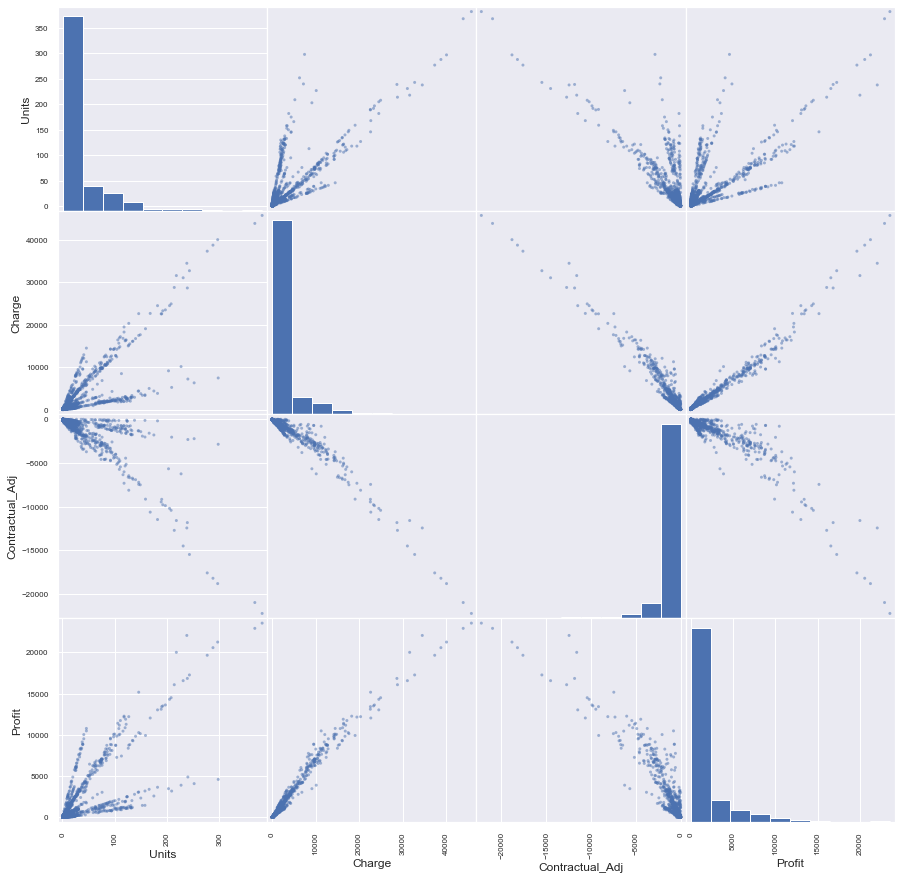

In [26]:
pd.plotting.scatter_matrix(df_monthly, alpha=0.5, diagonal = 'hist', figsize=(15, 15))
plt.show()

In [27]:
df_monthly.to_csv('df_monthly.csv', header = df_monthly.columns, index = True, encoding = 'utf-8')

In [28]:
df_raw.to_csv('df_raw.csv', header = df_raw.columns, index = True, encoding = 'utf-8')

## Designate Patient's Age Group from Well Visit CPT code

In [ ]:
# 99381, 99391: <1yr | 99382, 99392: 1-4yr | 99383, 99393: 5-11yr | 99384, 99394: 12-17yr | 99385, 99395: 18+yr
# designate patient age group at end of time period
patient_age = {}
def ages(patient_id, value):
    patient = patient_id.apply(str)
    for pat, val in zip(patient, value):
        if val == 99381 or val == 99391:
            patient_age[pat] = '<1yr'
        elif val == 99382 or val == 99392:
            patient_age[pat] = '1-4yrs'
        elif val == 99383 or val == 99393:
            patient_age[pat] = '5-11yrs'
        elif val == 99384 or val == 99394:
            patient_age[pat] = '12-17yrs'
        elif val == 99385 or val == 99395:
            patient_age[pat] = '18+yrs'
        else:
            patient_age[pat] = patient_age.get(pat, 'Unknown')
df_raw_sort = df_raw.sort_values(by=['Patient_Id', 'Date'], ascending = True)
ages(df_raw_sort['Patient_Id'], df_raw_sort['Procedure'])

In [ ]:
patients = pd.DataFrame.from_dict(patient_age, orient='index')
patients.columns = ['Age_Group']

#### Number of Patients that fall into each age group

In [ ]:
patients['Age_Group'].value_counts()

# Group by Patient

In [ ]:
df_raw['Patient_Id'] = df_raw['Patient_Id'].apply(str)
df_patient = df_raw.groupby(by=['Patient_Id', 'Insurance']).sum()
df_patient['Age_Group'] = df_patient.index.to_series().apply(lambda x: x[0]).map(patient_age)
# add column with average contractual adjustment per unit for each patient
df_patient['Norm_Cont_Adj'] = df_patient['Contractual_Adj'] / df_patient['Units']
df_patient.head(10)

### Patients who changed Insurances in the time period

In [ ]:
# list of patients who change insurances
check = dict()
for patient in df_patient.index.values:
    check[patient[0]] = check.get(patient[0], 0) + 1
mult_ins_pts = list()
for key, val in check.items():
    if (val >= 2):
        mult_ins_pts.append(key)

In [ ]:
df_mult_insurances = df_raw[df_raw['Patient_Id'].isin(mult_ins_pts)]
df_mult_insurances

In [ ]:
df_mult_grouped = df_mult_insurances.groupby(['Patient_Id', 'Insurance']).sum()
df_mult_grouped

## Group by Age Group, Count Largest Insurances per Age Group

In [ ]:
df_raw['Patient_Id'] = df_raw['Patient_Id'].apply(str)
df_raw['Age_Group'] = df_raw['Patient_Id'].map(patient_age)
df_raw

In [ ]:
df_top_ins_by_units = df_raw.groupby(['Age_Group','Insurance']).count().sort_values(by=['Units'], ascending=False)
df_top_ins_by_units.head(25)

In [ ]:
df_top_ins_by_charges = df_raw.groupby(['Age_Group','Insurance']).sum().sort_values(by=['Charge'], ascending=False)
df_top_ins_by_charges.head(25)

## Group by Age Group

In [ ]:
df_raw['Age_Group'] = df_raw['Patient_Id'].map(patient_age)
df_agegroup = df_raw.groupby(by=['Age_Group']).sum()[['Units', 'Charge', 'Contractual_Adj']]
df_agegroup['Charge_Per_Unit'] = df_agegroup['Charge'] / df_agegroup['Units']
df_agegroup['Adj_Per_Unit'] = df_agegroup['Contractual_Adj'] / df_agegroup['Units']
patients_per_age_group = patients['Age_Group'].value_counts().to_dict()
df_agegroup['Patient_Count'] = df_agegroup.index.map(patients_per_age_group)
df_agegroup['Units_Per_Patient'] = df_agegroup['Units'] / df_agegroup['Patient_Count']
df_agegroup['Charges_Per_Patient'] = df_agegroup['Charge'] / df_agegroup['Patient_Count']

In [ ]:
df_agegroup_for_bar = df_agegroup.sort_values(by='Units_Per_Patient', ascending = False)

In [ ]:
df_agegroup_for_char = df_agegroup.sort_values(by='Charges_Per_Patient', ascending = False)

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.xlabel("Age Group", fontsize=20)
plt.ylabel("Number of Charges per Patient", fontsize=20)
plt.title("Units per Age Group", fontsize=20)
sns.barplot(x = df_agegroup_for_bar.index.values, y = df_agegroup_for_bar['Units_Per_Patient'])

### Group by age group and insurance (only including insurances with visit count > 200)

In [ ]:
df_age_ins = df_raw.groupby(by=['Age_Group', 'Insurance'])[['Units', 'Charge', 'Contractual_Adj']].sum()
df_age_ins.head(50)

In [ ]:
df_age_ins['Charge_Per_Unit'] = df_age_ins['Charge'] / df_age_ins['Units']
df_age_ins['Adj_Per_Unit'] = df_age_ins['Contractual_Adj'] / df_age_ins['Units']
patients_per_age_group = patients['Age_Group'].value_counts().to_dict()
df_agegroup['Patient_Count'] = df_agegroup.index.map(patients_per_age_group)
df_agegroup['Units_Per_Patient'] = df_agegroup['Units'] / df_agegroup['Patient_Count']
df_agegroup['Charges_Per_Patient'] = df_agegroup['Charge'] / df_agegroup['Patient_Count']

In [ ]:
df_patient_top5 = df_patient.groupby(by=['Insurance']).filter(lambda x: len(x)>200)
df_patient_top5.reset_index()

In [ ]:
one = df_patient[df_patient['Age_Group'] == '<1yr']
two = df_patient[df_patient['Age_Group'] == '1-4yrs']
three = df_patient[df_patient['Age_Group'] == '5-11yrs']
four = df_patient[df_patient['Age_Group'] == '12-17yrs']
five = df_patient[df_patient['Age_Group'] == '18+yrs']
unknown = df_patient[df_patient['Age_Group'] == 'Unknown']
unknown = unknown.drop('71246') # drop massive outlier which ruins the 'Unknown' boxplot scale

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(35, 15))
fig.suptitle('Visit Count Distribution for Age Groups', fontsize=36)

# <1yr
sns.histplot(ax=axes[0,0], x=one['Units'])
axes[0,0].set_title('<1yr', fontsize=20)

# 1-4yrs
sns.histplot(ax=axes[0,1], x=two['Units'])
axes[0,1].set_title('1-4yrs', fontsize=20)

# 5-11yrs
sns.histplot(ax=axes[0,2], x=three['Units'])
axes[0,2].set_title('5-11yrs', fontsize=20)

# 12-17yrs
sns.histplot(ax=axes[1,0], x=four['Units'])
axes[1,0].set_title('12-17yrs', fontsize=20)

# 18+yrs
sns.histplot(ax=axes[1,1], x=five['Units'])
axes[1,1].set_title('18+yrs', fontsize=20)

# Unknown
sns.histplot(ax=axes[1,2], x=unknown['Units'])
axes[1,2].set_title('Unknown Age', fontsize=20)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(35, 15))
fig.suptitle('Charge Distribution for Age Groups', fontsize=36)

# <1yr
sns.boxplot(ax=axes[0,0], x=one['Charge'])
axes[0,0].set_title('<1yr', fontsize=20)

# 1-4yrs
sns.boxplot(ax=axes[0,1], x=two['Charge'])
axes[0,1].set_title('1-4yrs', fontsize=20)

# 5-11yrs
sns.boxplot(ax=axes[0,2], x=three['Charge'])
axes[0,2].set_title('5-11yrs', fontsize=20)

# 12-17yrs
sns.boxplot(ax=axes[1,0], x=four['Charge'])
axes[1,0].set_title('12-17yrs', fontsize=20)

# 18+yrs
sns.boxplot(ax=axes[1,1], x=five['Charge'])
axes[1,1].set_title('18+yrs', fontsize=20)

# Unknown
sns.boxplot(ax=axes[1,2], x=unknown['Charge'])
axes[1,2].set_title('Unknown Age', fontsize=20)

## Preliminary Correlation Analysis

In [ ]:
corr = df_agegroup.iloc[:,:].corr(method='pearson')
plt.figure(figsize=(10,10))
sns.heatmap(corr, vmax=1.0, vmin=-1.0, linewidth=0.01, square=True, annot=True, cmap='rocket', linecolor='black')
plt.show()

## Second Attempt at Patient Grouping (using cleaned total df)

In [ ]:
df_raw_clean['Patient_Id'] = df_raw_clean['Patient_Id'].apply(str)
df_pt_clean = df_raw_clean.groupby(by=['Patient_Id', 'Insurance']).sum()
df_pt_clean['Age_Group'] = df_pt_clean.index.to_series().apply(lambda x: x[0]).map(patient_age)
# add column with average contractual adjustment per unit for each patient
#df_pt_clean['Norm_Cont_Adj'] = df_pt_clean['Contractual_Adj'] / df_pt_clean['Units']
df_pt_clean.head(10)

In [ ]:
df_ageins_clean = df_pt_clean.groupby(by=['Age_Group','Insurance']).mean()

In [ ]:
df_ageins_clean

In [ ]:
df_clean_top = df_raw_clean.groupby(by=['Insurance']).filter(lambda x: len(x)>500)
df_clean_top['Patient_Id'] = df_clean_top['Patient_Id'].apply(str)

df_pt_clean_top = df_clean_top.groupby(by=['Patient_Id', 'Insurance']).sum()
df_pt_clean_top['Age_Group'] = df_pt_clean_top.index.to_series().apply(lambda x: x[0]).map(patient_age)

df_ageins_clean_top = df_pt_clean_top.groupby(by=['Age_Group','Insurance']).mean()
df_ageins_clean_top['ContAdj_per_unit'] = df_ageins_clean_top['Contractual_Adj'] / df_ageins_clean_top['Units']
df_ageins_clean_top['Avg_Revenue'] = df_ageins_clean_top['Charge'] - abs(df_ageins_clean_top['Contractual_Adj'])
df_ageins_clean_top.sort_values(by=['Age_Group', 'Units'], ascending = True)

In [ ]:
df_total_comparison = df_pt_clean_top.groupby(by=['Age_Group','Insurance']).sum()
df_total_comparison.sort_values(by=['Age_Group', 'Units'], ascending = True)

#### Remove Insurances where Units < 12 (Units indicates number of charges billed to Insurance)

In [ ]:
df = df_raw.groupby('Insurance').filter(lambda x: len(x)>12)

## Aggregated Analysis

In [ ]:
# Create an aggregated total of charges, contractual adjustments, and visit counts by insurance
price_df = df[['Charge','Contractual_Adj', 'Insurance']].groupby("Insurance").sum()
price_df['Counts'] = df.value_counts().groupby("Insurance").sum()
price_df['Percent_Lost'] = -100*(price_df['Contractual_Adj'] / price_df['Charge'])
# remove specific insurance with unit > 12 but total charges negligible
price_df = price_df[price_df.index!='Disability Determination Payor']
price_df['Ins_abbs'] = ['ATCM', 'A', 'AS', 'AvC', 'ABS', 'Am', 'BCPPO', 'BCFEP', 'BCNC', 'BCSC', 'BCCP', 'C', 'CPPO',
                        'CBSI', 'EH', 'FCM', 'GEHA', 'GR', 'HBM', 'H', 'KBA', 'LH', 'M', 'MS', 'MSC', 'MHA', 'MHM', 
                        'NGAH', 'NoIns', 'PHCS', 'TSR', 'TH', 'TSB', 'UMR', 'UH']



In [ ]:
price_df

### Visits by Insurance

In [ ]:
Insurance_abbs = price_df.sort_values(by=['Counts'], ascending=False)['Ins_abbs']
Counts = price_df.sort_values(by=['Counts'], ascending=False)['Counts']
fig = plt.figure(figsize=(35,15))
plt.xlabel("Insurance (Abbreviated)", fontsize=36)
plt.ylabel("Visits", fontsize=36)
plt.title("Number of Visits by Insurance", fontsize=36)
bar = plt.bar(Insurance_abbs, Counts)

### Percent Revenue Adjusted per Insurance

In [ ]:
Insurance_abbs = price_df.sort_values(by=['Percent_Lost'], ascending=False)['Ins_abbs']
Perc = price_df.sort_values(by=['Percent_Lost'], ascending=False)['Percent_Lost']
fig = plt.figure(figsize=(35,15))
plt.xlabel("Insurance (Abbreviated)", fontsize=36)
plt.ylabel("Percent of Revenue Adjusted", fontsize=36)
plt.title("Percent of Revenue Adjusted by Insurance", fontsize=36)
bar = plt.bar(Insurance_abbs, Perc)

### Total Revenue Adjusted per Insurance

In [ ]:
Insurance_abbs = price_df.sort_values(by=['Contractual_Adj'], ascending=True)['Ins_abbs']
Counts = price_df.sort_values(by=['Contractual_Adj'], ascending=True)['Contractual_Adj']
fig = plt.figure(figsize=(35,15))
plt.xlabel("Insurance (Abbreviated)", fontsize=36)
plt.ylabel("Revenue Adjusted", fontsize=36)
plt.title("Revenue Adjusted by Insurance", fontsize=36)
bar = plt.bar(Insurance_abbs, Counts)

## Analysis by Date

In [ ]:
# convert date columns to usable datetime objects
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
data = df.groupby('Insurance').filter(lambda x: len(x)>50)
data.value_counts().groupby('Insurance').sum()

In [ ]:
fig = plt.figure(figsize=(25,12))
plt.title("Weekly Visits by 19 Largest Insurances", fontsize=36)
plt.xlabel("Date", fontsize=20)
plt.ylabel("Visit Count", fontsize=20)
custom_palette = sns.color_palette("Paired", 19)
sns.histplot(x=data['Date'], hue=data['Insurance'], stat='count',
             bins=117, multiple='stack')

## Visit Count Analysis by Patient

In [ ]:
pt_data = df.groupby(['Patient_Id','Insurance']).sum()
pt_data['CPT_Counts'] = df.value_counts().groupby('Patient_Id').sum()
pt_data = pt_data.sort_values(by=['Charge'], ascending=False)

In [ ]:
pt_data

In [ ]:
pt_data.describe()